In [75]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
from torchvision.datasets import DatasetFolder
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

## Training 3D autoencoder on EEG spectrum data 

In [28]:
class EEGDataset(Dataset):
    def __init__(self, csv_file, transform=None):

        self.data = pd.read_csv(csv_file)
        self.diagnosis_map ={'MDD': 1.0, 'Health': 0.0}
        self.transform =transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):

        raw = self.data.iloc[idx]
        eeg =np.load(raw['file'])
        label =self.diagnosis_map[raw['diagnosis']]
      
        if self.transform:
            eeg = self.transform(eeg)

        return eeg[np.newaxis,:12,:,:], label

In [29]:
train_dataset =EEGDataset('spectrums_short/train.csv')
val_dataset =EEGDataset('spectrums_short/val.csv')

In [30]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, drop_last = True)

In [55]:
class EEGAutoencoder(nn.Module):
    def __init__(self):
        super(EEGAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, 3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ELU(True),
            nn.MaxPool3d(2, stride=2),  # b, 16, 5, 5
            nn.Conv3d(16, 8, 3, stride=1, padding=1),  # b, 8, 3, 3
            nn.BatchNorm3d(8),
            nn.ELU(True),
            nn.MaxPool3d(2, stride=2),  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(8, 16, 2, stride=2),  # b, 16, 5, 5
            nn.ELU(True),
            nn.BatchNorm3d(16),
            nn.ConvTranspose3d(16, 1, 2, stride=2),  # b, 8, 15, 15
            nn.BatchNorm3d(1),
            nn.ELU(True)
        )
        self.pool =nn.AdaptiveAvgPool3d((8,8,8))
        self.fc = nn.Linear(8*8*64, 2)


    def forward(self, x):
        original_shapes =x.shape
        codes = self.encoder(x)
        classes =self.pool(codes)
        classes =self.fc(classes.view(-1,8*8*64))
        
        x = self.decoder(codes)
        x =nn.functional.interpolate(x, size=original_shapes[2:])
        return codes,x,classes

learning_rate =0.001
num_epochs =800

In [80]:
learning_rate =0.0001
num_epochs =500

In [81]:
## 0.001 -the best 

In [82]:
model = EEGAutoencoder().cuda()
criterion = nn.MSELoss()
cr_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-1)

In [83]:
batch, labels =next(iter(train_loader))

In [84]:
batch =batch.float().cuda()

In [85]:
batch.shape

torch.Size([4, 1, 12, 24, 98])

In [86]:
def plot_batch_and_outputs(batch, outputs, show_type ='img'):
    Y_ticks =np.linspace(0, 128, num=98)
    X_ticks =np.linspace(0, 45, num=24)
    random_channel =np.random.randint(batch.shape[1])
    levels =45
    
    if show_type =='img':
        print('True: ')
        spectrum = plt.imshow(batch[0,0,random_channel,:,:].detach().cpu().numpy(),cmap='jet')
        plt.show()
        print('Predicted: ')
        spectrum = plt.imshow(outputs[0,0,random_channel,:,:].detach().cpu().numpy(), cmap='jet')
        plt.show()
    else:
        spectrum = plt.contourf(Y_ticks,X_ticks,batch[0,0,random_channel,:,:].detach().cpu().numpy(),levels, cmap='jet')
        plt.show()
        print('Predicted: ')
        spectrum = plt.contourf(Y_ticks,X_ticks,outputs[0,0,random_channel,:,:].detach().cpu().numpy(),levels, cmap='jet')
        plt.show()

In [87]:
codes,output, pred =model(batch)

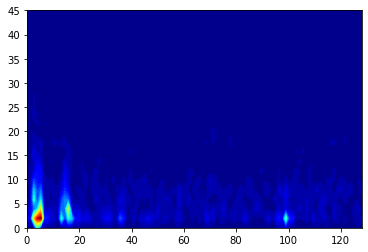

Predicted: 


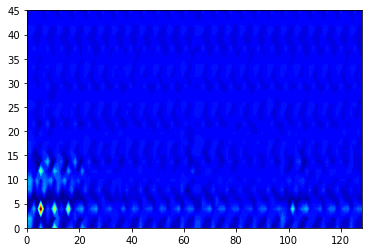

In [90]:
plot_batch_and_outputs(batch, output,show_type ='c')

In [91]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.acc_score_max = -np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, acc_score, model):

        score = acc_score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(acc_score, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(acc_score, model)
            self.counter = 0

    def save_checkpoint(self, acc_score, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Accuracy score inscreased ({self.acc_score_max:.6f} --> {acc_score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'models/checkpoint_{acc_score:.6f}.pt')
        self.acc_score_max = acc_score

In [92]:
early_stopping =EarlyStopping(patience=500,verbose=True)

In [93]:
writer = SummaryWriter('runs/base_autoencoder3d_v2')

In [94]:
for epoch in range(num_epochs):
    train_loss = 0
    train_correct =0
    train_total =0
    for data in train_loader:
        img, label = data
        img = img.float().cuda()
        label=label.long().cuda()
        # ===================forward=====================
        codes, output, preds = model(img)
        _, predicted = torch.max(preds.data, 1)
        train_correct += (predicted == label).sum().item()
        train_total+= labels.size(0)
        l2_loss = criterion(output, img)
        cr_loss1 =cr_loss(preds,label)
        loss =l2_loss+cr_loss1
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data
    # ===================log========================
    if epoch % 1 == 0:
        with torch.no_grad():
            val_loss =0
            val_correct =0
            val_total =0
            for data in val_loader: 
                img, label = data
                img = img.float().cuda()
                label=label.long().cuda()
                codes,output, preds  = model(img)
                _, predicted = torch.max(preds.data, 1)
                val_correct += (predicted == label).sum().item()
                val_total+= labels.size(0)
                l2_loss = criterion(output, img)
                cr_loss1 =cr_loss(preds,label)
                # Train model with two losses 
                loss =l2_loss+cr_loss1
                val_loss += loss.data
            writer.add_scalar('training loss',
                            train_loss/train_total,
                            epoch)
            writer.add_scalar('validation loss',
                            val_loss/val_total,
                            epoch)
            writer.add_scalar('train accuracy',
                            train_correct/ train_total,
                            epoch)
            writer.add_scalar('val accuracy',
                            val_correct/ val_total,
                            epoch)
            
            print('epoch [{}/{}], train loss:{:.4f}'.format(epoch+1, num_epochs, train_loss/train_total))    
            print('epoch [{}/{}], val loss:{:.4f}'.format(epoch+1, num_epochs,val_loss/ val_total))
            print('epoch [{}/{}], train accuracy:{:.4f}'.format(epoch+1, num_epochs, train_correct/ train_total)) 
            print('epoch [{}/{}], val accuracy:{:.4f}'.format(epoch+1, num_epochs, val_correct/ val_total)) 
            #plot_batch_and_outputs(img, output,show_type ='c')
            early_stopping(val_correct/ val_total, model)
        
            if early_stopping.early_stop:
                print("Early stopping")
                break


232
68
epoch [1/500], train loss:0.7538
epoch [1/500], val loss:0.6357
epoch [1/500], train accuracy:0.4353
epoch [1/500], val accuracy:0.5294
Accuracy score inscreased (-inf --> 0.529412).  Saving model ...
232
68
epoch [2/500], train loss:0.6910
epoch [2/500], val loss:0.6355
epoch [2/500], train accuracy:0.5302
epoch [2/500], val accuracy:0.4706
EarlyStopping counter: 1 out of 50
232
68
epoch [3/500], train loss:0.6479
epoch [3/500], val loss:0.5729
epoch [3/500], train accuracy:0.5474
epoch [3/500], val accuracy:0.4706
EarlyStopping counter: 2 out of 50
232
68
epoch [4/500], train loss:0.6082
epoch [4/500], val loss:0.5289
epoch [4/500], train accuracy:0.5905
epoch [4/500], val accuracy:0.5000
EarlyStopping counter: 3 out of 50
232
68
epoch [5/500], train loss:0.5900
epoch [5/500], val loss:0.5102
epoch [5/500], train accuracy:0.6078
epoch [5/500], val accuracy:0.5000
EarlyStopping counter: 4 out of 50
232
68
epoch [6/500], train loss:0.5717
epoch [6/500], val loss:0.4921
epoch [6/

232
68
epoch [45/500], train loss:0.3410
epoch [45/500], val loss:0.3824
epoch [45/500], train accuracy:0.9095
epoch [45/500], val accuracy:0.6618
EarlyStopping counter: 13 out of 50
232
68
epoch [46/500], train loss:0.3420
epoch [46/500], val loss:0.3591
epoch [46/500], train accuracy:0.8922
epoch [46/500], val accuracy:0.7206
Accuracy score inscreased (0.720588 --> 0.720588).  Saving model ...
232
68
epoch [47/500], train loss:0.3397
epoch [47/500], val loss:0.3872
epoch [47/500], train accuracy:0.9224
epoch [47/500], val accuracy:0.5294
EarlyStopping counter: 1 out of 50
232
68
epoch [48/500], train loss:0.3481
epoch [48/500], val loss:0.3626
epoch [48/500], train accuracy:0.8578
epoch [48/500], val accuracy:0.6765
EarlyStopping counter: 2 out of 50
232
68
epoch [49/500], train loss:0.3284
epoch [49/500], val loss:0.3841
epoch [49/500], train accuracy:0.9397
epoch [49/500], val accuracy:0.6765
EarlyStopping counter: 3 out of 50
232
68
epoch [50/500], train loss:0.3316
epoch [50/500]

232
68
epoch [90/500], train loss:0.2624
epoch [90/500], val loss:0.3733
epoch [90/500], train accuracy:0.9828
epoch [90/500], val accuracy:0.6912
EarlyStopping counter: 44 out of 50
232
68
epoch [91/500], train loss:0.2638
epoch [91/500], val loss:0.3729
epoch [91/500], train accuracy:0.9828
epoch [91/500], val accuracy:0.7206
Accuracy score inscreased (0.720588 --> 0.720588).  Saving model ...
232
68
epoch [92/500], train loss:0.2584
epoch [92/500], val loss:0.3774
epoch [92/500], train accuracy:0.9871
epoch [92/500], val accuracy:0.7059
EarlyStopping counter: 1 out of 50
232
68
epoch [93/500], train loss:0.2629
epoch [93/500], val loss:0.3796
epoch [93/500], train accuracy:0.9871
epoch [93/500], val accuracy:0.6765
EarlyStopping counter: 2 out of 50
232
68
epoch [94/500], train loss:0.2562
epoch [94/500], val loss:0.3816
epoch [94/500], train accuracy:0.9871
epoch [94/500], val accuracy:0.7059
EarlyStopping counter: 3 out of 50
232
68
epoch [95/500], train loss:0.2583
epoch [95/500]

232
68
epoch [134/500], train loss:0.2392
epoch [134/500], val loss:0.3898
epoch [134/500], train accuracy:0.9871
epoch [134/500], val accuracy:0.7353
Accuracy score inscreased (0.735294 --> 0.735294).  Saving model ...
232
68
epoch [135/500], train loss:0.2399
epoch [135/500], val loss:0.3752
epoch [135/500], train accuracy:0.9871
epoch [135/500], val accuracy:0.7059
EarlyStopping counter: 1 out of 50
232
68
epoch [136/500], train loss:0.2381
epoch [136/500], val loss:0.3960
epoch [136/500], train accuracy:0.9871
epoch [136/500], val accuracy:0.6765
EarlyStopping counter: 2 out of 50
232
68
epoch [137/500], train loss:0.2371
epoch [137/500], val loss:0.4017
epoch [137/500], train accuracy:0.9828
epoch [137/500], val accuracy:0.6765
EarlyStopping counter: 3 out of 50
232
68
epoch [138/500], train loss:0.2409
epoch [138/500], val loss:0.3810
epoch [138/500], train accuracy:0.9871
epoch [138/500], val accuracy:0.7059
EarlyStopping counter: 4 out of 50
232
68
epoch [139/500], train loss:0

232
68
epoch [178/500], train loss:0.2322
epoch [178/500], val loss:0.3907
epoch [178/500], train accuracy:0.9871
epoch [178/500], val accuracy:0.7206
EarlyStopping counter: 34 out of 50
232
68
epoch [179/500], train loss:0.2321
epoch [179/500], val loss:0.3913
epoch [179/500], train accuracy:0.9871
epoch [179/500], val accuracy:0.6912
EarlyStopping counter: 35 out of 50
232
68
epoch [180/500], train loss:0.2306
epoch [180/500], val loss:0.3953
epoch [180/500], train accuracy:0.9871
epoch [180/500], val accuracy:0.6912
EarlyStopping counter: 36 out of 50
232
68
epoch [181/500], train loss:0.2307
epoch [181/500], val loss:0.3851
epoch [181/500], train accuracy:0.9871
epoch [181/500], val accuracy:0.7353
Accuracy score inscreased (0.735294 --> 0.735294).  Saving model ...
232
68
epoch [182/500], train loss:0.2340
epoch [182/500], val loss:0.3904
epoch [182/500], train accuracy:0.9871
epoch [182/500], val accuracy:0.7059
EarlyStopping counter: 1 out of 50
232
68
epoch [183/500], train los

232
68
epoch [222/500], train loss:0.2305
epoch [222/500], val loss:0.3946
epoch [222/500], train accuracy:0.9871
epoch [222/500], val accuracy:0.7059
EarlyStopping counter: 13 out of 50
232
68
epoch [223/500], train loss:0.2302
epoch [223/500], val loss:0.3826
epoch [223/500], train accuracy:0.9871
epoch [223/500], val accuracy:0.6618
EarlyStopping counter: 14 out of 50
232
68
epoch [224/500], train loss:0.2882
epoch [224/500], val loss:0.3932
epoch [224/500], train accuracy:0.9871
epoch [224/500], val accuracy:0.7206
EarlyStopping counter: 15 out of 50
232
68
epoch [225/500], train loss:0.2303
epoch [225/500], val loss:0.3898
epoch [225/500], train accuracy:0.9871
epoch [225/500], val accuracy:0.7353
Accuracy score inscreased (0.735294 --> 0.735294).  Saving model ...
232
68
epoch [226/500], train loss:0.2272
epoch [226/500], val loss:0.3901
epoch [226/500], train accuracy:0.9871
epoch [226/500], val accuracy:0.7206
EarlyStopping counter: 1 out of 50
232
68
epoch [227/500], train los

232
68
epoch [266/500], train loss:0.2320
epoch [266/500], val loss:0.3862
epoch [266/500], train accuracy:0.9871
epoch [266/500], val accuracy:0.6765
EarlyStopping counter: 1 out of 50
232
68
epoch [267/500], train loss:0.2241
epoch [267/500], val loss:0.3917
epoch [267/500], train accuracy:0.9871
epoch [267/500], val accuracy:0.6618
EarlyStopping counter: 2 out of 50
232
68
epoch [268/500], train loss:0.2233
epoch [268/500], val loss:0.3928
epoch [268/500], train accuracy:0.9871
epoch [268/500], val accuracy:0.6618
EarlyStopping counter: 3 out of 50
232
68
epoch [269/500], train loss:0.2238
epoch [269/500], val loss:0.3908
epoch [269/500], train accuracy:0.9871
epoch [269/500], val accuracy:0.6912
EarlyStopping counter: 4 out of 50
232
68
epoch [270/500], train loss:0.2263
epoch [270/500], val loss:0.3994
epoch [270/500], train accuracy:0.9871
epoch [270/500], val accuracy:0.6912
EarlyStopping counter: 5 out of 50
232
68
epoch [271/500], train loss:0.2269
epoch [271/500], val loss:0.

232
68
epoch [310/500], train loss:0.2206
epoch [310/500], val loss:0.3792
epoch [310/500], train accuracy:0.9871
epoch [310/500], val accuracy:0.6912
EarlyStopping counter: 32 out of 50
232
68
epoch [311/500], train loss:0.2234
epoch [311/500], val loss:0.3903
epoch [311/500], train accuracy:0.9871
epoch [311/500], val accuracy:0.6471
EarlyStopping counter: 33 out of 50
232
68
epoch [312/500], train loss:0.2244
epoch [312/500], val loss:0.3779
epoch [312/500], train accuracy:0.9871
epoch [312/500], val accuracy:0.6765
EarlyStopping counter: 34 out of 50
232
68
epoch [313/500], train loss:0.2222
epoch [313/500], val loss:0.3806
epoch [313/500], train accuracy:0.9871
epoch [313/500], val accuracy:0.6618
EarlyStopping counter: 35 out of 50
232
68
epoch [314/500], train loss:0.2226
epoch [314/500], val loss:0.3806
epoch [314/500], train accuracy:0.9871
epoch [314/500], val accuracy:0.7206
EarlyStopping counter: 36 out of 50
232
68
epoch [315/500], train loss:0.2253
epoch [315/500], val lo

In [20]:
codes_data =[]
labels_data =[]

In [21]:
for data in train_loader:
    img, label = data
    img = img.float().cuda()
    codes,output,preds = model(img)
    codes_data.append(codes.detach().cpu().numpy())
    labels_data.append(label.detach().cpu().numpy())
with torch.no_grad():
    for data in val_loader: 
        img, label = data
        img = img.float().cuda()
        codes,output,preds = model(img)
        codes_data.append(codes.detach().cpu().numpy())
        labels_data.append(label.detach().cpu().numpy())
       

In [22]:
X=np.concatenate(codes_data)
X =X.reshape(158,-1)
y=np.concatenate(labels_data)

In [23]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pathlib import Path

In [24]:
def build_models(X,y):    
    models = {
        'lr_l1': LogisticRegression(penalty='l1',solver='liblinear',C =1),
        'lr_l2': LogisticRegression(penalty='l2',solver='liblinear',C =1),
        'rf_7': RandomForestClassifier(n_estimators=100, max_depth=7),
        'rf_5': RandomForestClassifier(n_estimators=100, max_depth=5),
        'svm_stand_0.1': svm.SVC(C=0.1),
        'svm_stand_0.01': svm.SVC(C=0.01),
        'knn': KNeighborsClassifier(n_neighbors=10),
        'gb': GradientBoostingClassifier(max_depth=5)
    }
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
        print(name, f"{scores.mean():.3f}+/-{scores.std():.3f}")
    

In [37]:
build_models(X,y)

lr_l1 0.544+/-0.159
lr_l2 0.580+/-0.111
rf_7 0.547+/-0.118
rf_5 0.563+/-0.125
svm_stand_0.1 0.490+/-0.135
svm_stand_0.01 0.487+/-0.135
knn 0.480+/-0.151
gb 0.583+/-0.108


In [62]:
y.shape

(158,)